In [5]:
# ***Description***

# Geoffrey Richards
# 12/10/2023
# Supervised Machine Learning Final Project: Computational Finance

#Import libraries.
import os
import pandas
from datetime import datetime
import matplotlib.pylab as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score, GridSearchCV

# In this report we will use financial data collected by an individual contributor on Kaggle to estimate the Listing Price of a
# new company that is reaching its initial public offering (IPO).

# The data can be found at this location: https://www.kaggle.com/datasets/nikhilraj7700/ipo-watch-debuts-gmps-trajectories/download?datasetVersionNumber=1.

# The supervised machine learning regression problem can be stated as: Predict the Listing Price of a company given features 
# included in the data set prior to the company's official listing.


In [6]:
# ***EDA Procedure***

# First we will visually inspect the data.  We can see the data contains the name of the IPO and therefore name of the company.
# It also contains the Listing Date, which could be usefull as inflation may drive up the listing price.  IT contains the IPO size
# in millions (number of shares). The subscription rate, also in millions.  The subscription is the number of bids over the IPO size
# received.  Clearly IPO size and subscription could be useful for determing the ultimate listing price of the IPO.  The GMP, or
# grey market premium is the unofficial price over the IPO price at which shares for the company are trading prior to listing.
# The IPO price is the official price of shares prior to listing.  The estimated price would be estimates provided prior to the IPO
# for the listing price.  The estimated percentage would be the percentage of the estimated price over the IPO price at which
# the individuals making the estimate might expect the listing price to land.  The LT price would be the longterm price of shares
# for a given company after many months of trading, and the LT percentage would be the percentage over the listing price of the long
# term price after many months of trading.

# Finally, the listing price is the value we're trying to estimate. Upon the IPO, the IPO price will be received by traders, but 
# upon listing the price will be immediately bid up or down depending upon the actual perceived value of the company.  That
# value is what we're trying to estimate.  This could be important because if we estimate the IPO price is substantially lower
# than the listing price, and we have an opportunity to pay something closer to the IPO price than what we estimate the listing price
# to be, then we have an opportunity to turn a profit very rapidly, possibly in less than a day.

# Lets look at the top five rows of the data to determine if there's any data pruning we need to perform:
# (Note the data is stored in a .zip file so I just downloaded it and then placed it in a known location)

data = pandas.read_csv(r"C:\Users\14436\Desktop\ml_final_project\archive\gmp_performance.csv")
data.head()

,IPO,Listing Date,IPO_Size,Subscription,GMP,IPO Price,Estimated Price,Estimated Percentage,Listing Price,Listing Percentage,LT Price,LT Percentage
0,"ASK Automotive IPO (ASKAUTOLTD,544022)",15-11-2023,834.00,51.14,28,282,310,9.93,303,7.55,294.0,4.43
1,Protean eGov Technologies IPO (544021),13-11-2023,490.33,23.86,48,792,840,6.06,792,0.00,1109.0,40.04
2,"ESAF Small Finance IPO (ESAFSFB,544020)",10-11-2023,463.00,77.00,16,60,76,26.67,71,18.33,68.0,13.58
3,"Honasa Consumer Limited IPO (HONASA,544014)",07-11-2023,1701.44,7.61,24,324,348,7.41,330,1.85,475.0,46.64
4,"Cello World Limited IPO (CELLO,544012)",06-11-2023,1900.00,41.69,160,648,808,24.69,829,27.93,781.0,20.54


In [7]:
# To begin with, any textual analysis of the names and correlation between such names and the listing price after IPO of a given
# company is beyond the scope of this project. As a result, each row can simply be thought of as a data point.  The names of each
# IPO is irrelevant, so as our first step, lets drop the first column, the IPO name.

data = data.drop(['IPO'], axis=1)
data.head()

,Listing Date,IPO_Size,Subscription,GMP,IPO Price,Estimated Price,Estimated Percentage,Listing Price,Listing Percentage,LT Price,LT Percentage
0,15-11-2023,834.00,51.14,28,282,310,9.93,303,7.55,294.0,4.43
1,13-11-2023,490.33,23.86,48,792,840,6.06,792,0.00,1109.0,40.04
2,10-11-2023,463.00,77.00,16,60,76,26.67,71,18.33,68.0,13.58
3,07-11-2023,1701.44,7.61,24,324,348,7.41,330,1.85,475.0,46.64
4,06-11-2023,1900.00,41.69,160,648,808,24.69,829,27.93,781.0,20.54


In [8]:
# Now upon inspecting certian rows of the data, we notice that there are some entries left blank.

print(data.iloc[-9])

# They are filled in with NaNs by the pandas library when read with csv read. As not many rows were present in the data, lets
# drop the rows with NaNs.

data = data.dropna()

# We can see that the row under examination previously was dropped as it contained a NaN value.

print(data.iloc[-9])

Listing Date            14-12-2020
IPO_Size                     810.0
Subscription                156.65
GMP                             43
IPO Price                       60
Estimated Price                103
Estimated Percentage         71.67
Listing Price                  115
Listing Percentage           92.25
LT Price                       NaN
LT Percentage                  NaN
Name: 143, dtype: object
Listing Date            29-01-2021
IPO_Size                   4633.38
Subscription                  3.49
GMP                              0
IPO Price                       26
Estimated Price                 26
Estimated Percentage           1.0
Listing Price                   25
Listing Percentage           -3.85
LT Price                      76.0
LT Percentage               192.69
Name: 140, dtype: object


In [9]:
# As previously discussed, the IPO date may very well be important as inflation could play a roll in listing price.
# Unfortunately, we can't simply use the listing date as a data point. We need to convert it to seconds and then place it on a
# uniform scale starting at 0.

# First lets convert the date to seconds.

dateSeconds = []

for date in data['Listing Date']:
    dateSeconds.append((datetime.strptime(date, '%d-%m-%Y') - datetime(1900, 1, 1)).total_seconds())
    
data['Date Time Seconds'] = dateSeconds

# Now lets level the seconds column by setting the earliest date to 0 and having all other date seconds count off of that point
# in time.

data['Date Time Seconds'] = data['Date Time Seconds'] - data['Date Time Seconds'].iloc[-1]

# We can see that the adjustments we made worked and are stored in the Date Time Seconds column.

data.head()

,Listing Date,IPO_Size,Subscription,GMP,IPO Price,Estimated Price,Estimated Percentage,Listing Price,Listing Percentage,LT Price,LT Percentage,Date Time Seconds
0,15-11-2023,834.00,51.14,28,282,310,9.93,303,7.55,294.0,4.43,99360000.0
1,13-11-2023,490.33,23.86,48,792,840,6.06,792,0.00,1109.0,40.04,99187200.0
2,10-11-2023,463.00,77.00,16,60,76,26.67,71,18.33,68.0,13.58,98928000.0
3,07-11-2023,1701.44,7.61,24,324,348,7.41,330,1.85,475.0,46.64,98668800.0
4,06-11-2023,1900.00,41.69,160,648,808,24.69,829,27.93,781.0,20.54,98582400.0


In [10]:
# Now lets remove certain columns that will likely not contribute to our prediction.  Firstly, we can remove the Listing Date
# as we just created a Date Time Seconds column to replace it with a more useful set of values.  Second, given the problem statement
# and our original data inquiry, we can deduce that the Listing Percentage, LT Price, and LT Percentage are not relevant
# to the prediction task at hand.  This is due to the fact that we will not know any of these values until after the Listing Price
# has already been established.  Furthermore, its not clear what the 'longterm' price and percentage refer to in terms of time.
# As an example, if we take the long term price to be the price of one company 10 years after IPO while we take the long term
# price of another company to be the price of that company 10 months after IPO, clearly the two values will vary wildly simply
# due to the amount of time given to the first company's share price to accrue and fluctuate. As a result, LT Price and Percentage
# won't help us and probably would never have helped us without mroe information.

# The Listing Percentage is related to the difference between the listing price and the IPO price.  Clearly, you have to know
# the listing price to know the listing percentage and thus the listing percentage will not help us with our predicitions nor
# would we have it on hand to predict the listing price just prior to IPO.

# So lets get rid of these columns and look at what we have.

data = data.drop(['Listing Date','Listing Percentage','LT Price','LT Percentage'], axis=1)
data.head()

,IPO_Size,Subscription,GMP,IPO Price,Estimated Price,Estimated Percentage,Listing Price,Date Time Seconds
0,834.00,51.14,28,282,310,9.93,303,99360000.0
1,490.33,23.86,48,792,840,6.06,792,99187200.0
2,463.00,77.00,16,60,76,26.67,71,98928000.0
3,1701.44,7.61,24,324,348,7.41,330,98668800.0
4,1900.00,41.69,160,648,808,24.69,829,98582400.0


In [11]:
# Now we need to quickly convert all values to similar data types. Lets go with doubles.  We can see that some are 64 bit integers.

for column in data:
    print(type(data[column][0]))

<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.float64'>
<class 'numpy.int64'>
<class 'numpy.float64'>


In [12]:
# So we convert integers to doubles and make sure that our change worked.

data = data.astype(float)
for column in data:
    print(type(data[column][0]))

data.head()

<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>


,IPO_Size,Subscription,GMP,IPO Price,Estimated Price,Estimated Percentage,Listing Price,Date Time Seconds
0,834.00,51.14,28.0,282.0,310.0,9.93,303.0,99360000.0
1,490.33,23.86,48.0,792.0,840.0,6.06,792.0,99187200.0
2,463.00,77.00,16.0,60.0,76.0,26.67,71.0,98928000.0
3,1701.44,7.61,24.0,324.0,348.0,7.41,330.0,98668800.0
4,1900.00,41.69,160.0,648.0,808.0,24.69,829.0,98582400.0


In [13]:
# Now lets perform some more detailed exploratory data analysis. First lets look at the characteristics of the data.

# We can see that our means vary wildly, as is the case with our standard deviations. This is bad because it could
# really damage the ability of some models to make accurate prediction as the data is not even close to normalized and uniform.

# We do have the same counts, which is good because it means our previous NaN elimination routine worked.

# In any case, lets make sure to remember that we need to normalize data later on for modeling purposes.

data.describe(include='all')

,IPO_Size,Subscription,GMP,IPO Price,Estimated Price,Estimated Percentage,Listing Price,Date Time Seconds
count,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,1.430000e+02
mean,1494.592951,45.344755,107.405594,458.209790,565.615385,24.001818,568.657343,5.472020e+07
std,2634.844335,59.185029,187.397981,362.260117,474.881689,30.487795,488.962398,2.961164e+07
min,60.000000,0.120000,-80.000000,25.000000,26.000000,-11.000000,25.000000,0.000000e+00
25%,485.165000,3.585000,4.500000,186.000000,222.000000,1.815000,220.000000,3.002400e+07
50%,740.000000,20.290000,35.000000,353.000000,443.000000,11.390000,444.000000,5.244480e+07
75%,1399.220000,71.430000,125.000000,600.000000,768.500000,36.855000,755.000000,8.458560e+07
max,20557.000000,326.490000,1110.000000,2150.000000,2240.000000,138.040000,2607.000000,9.936000e+07


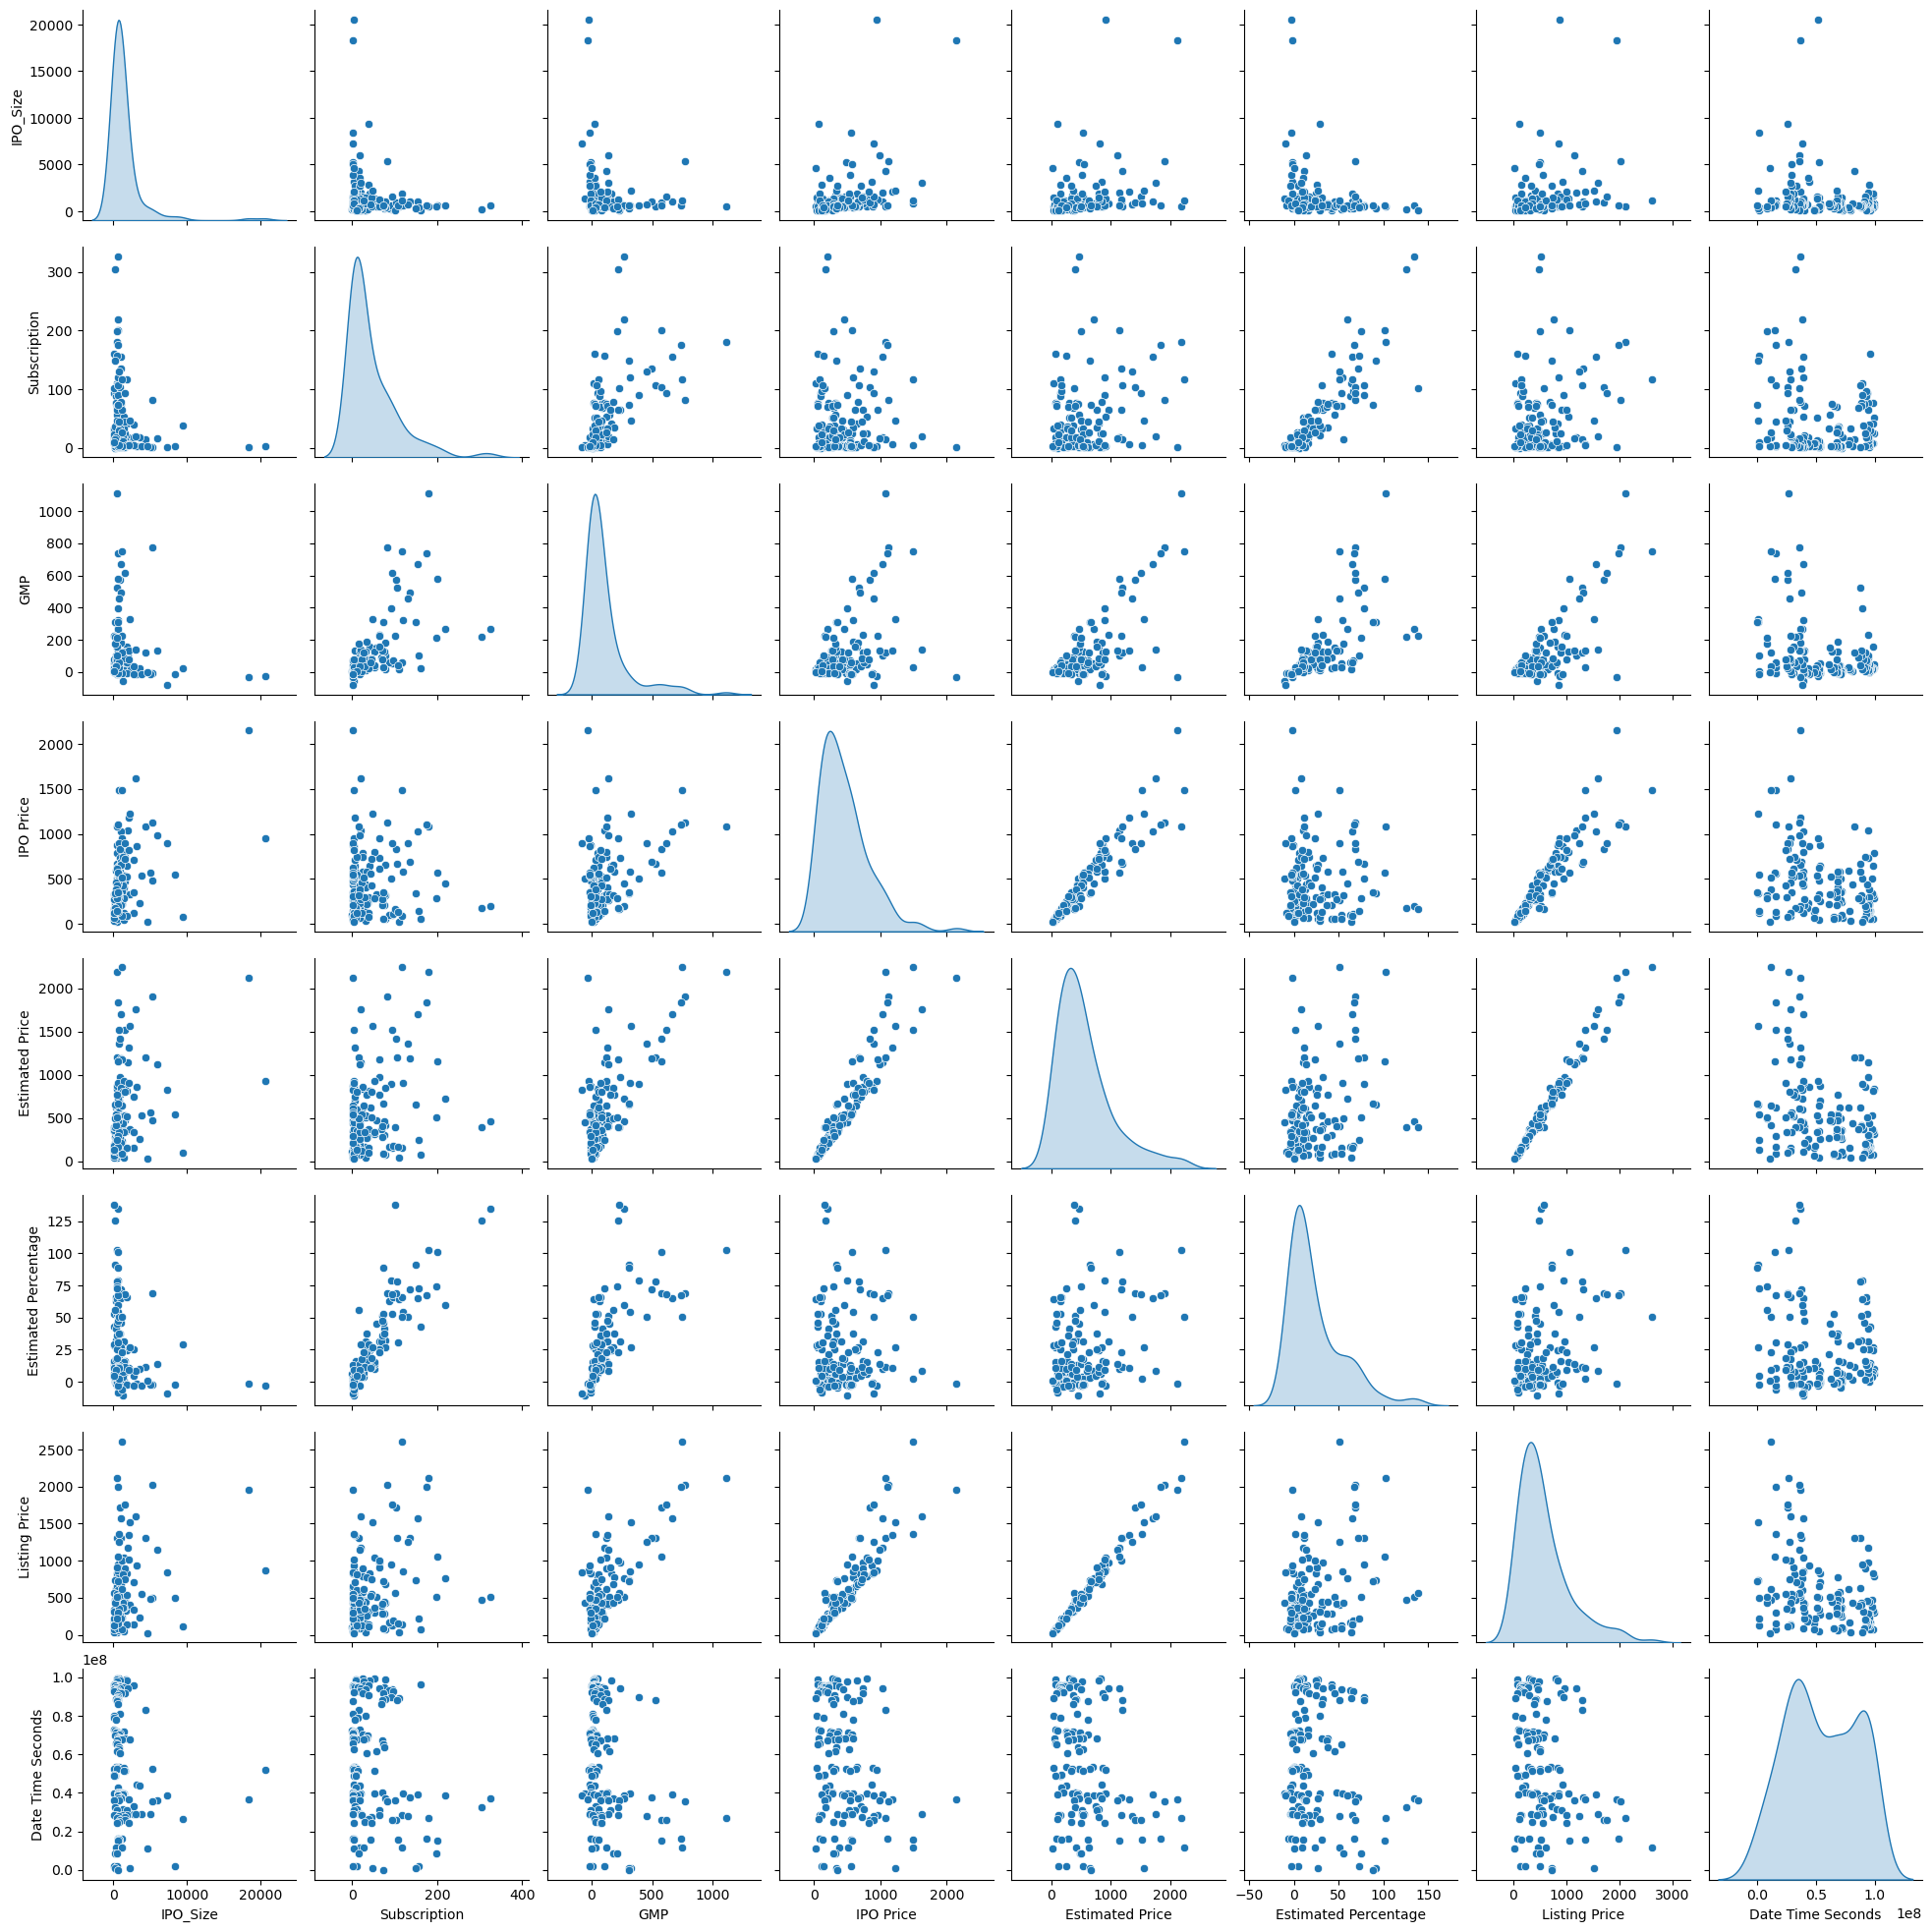

In [14]:
# Let's use a pair plot to see if we can discern any trends associated with the listing price column.

# We can see that the analyst estimated price, IPO price, and GMP seem to have a strong correlation with listing price.

# This is to be expected as the analysts estimating the price likely have a lot of information on what the listing price will be,
# the IPO price sets a baseline for the listing price, and the grey market price is related to what people will likely
# be trading the stock for after IPO.

pairPlot = sns.pairplot(data,diag_kind="kde") 
plt.show()

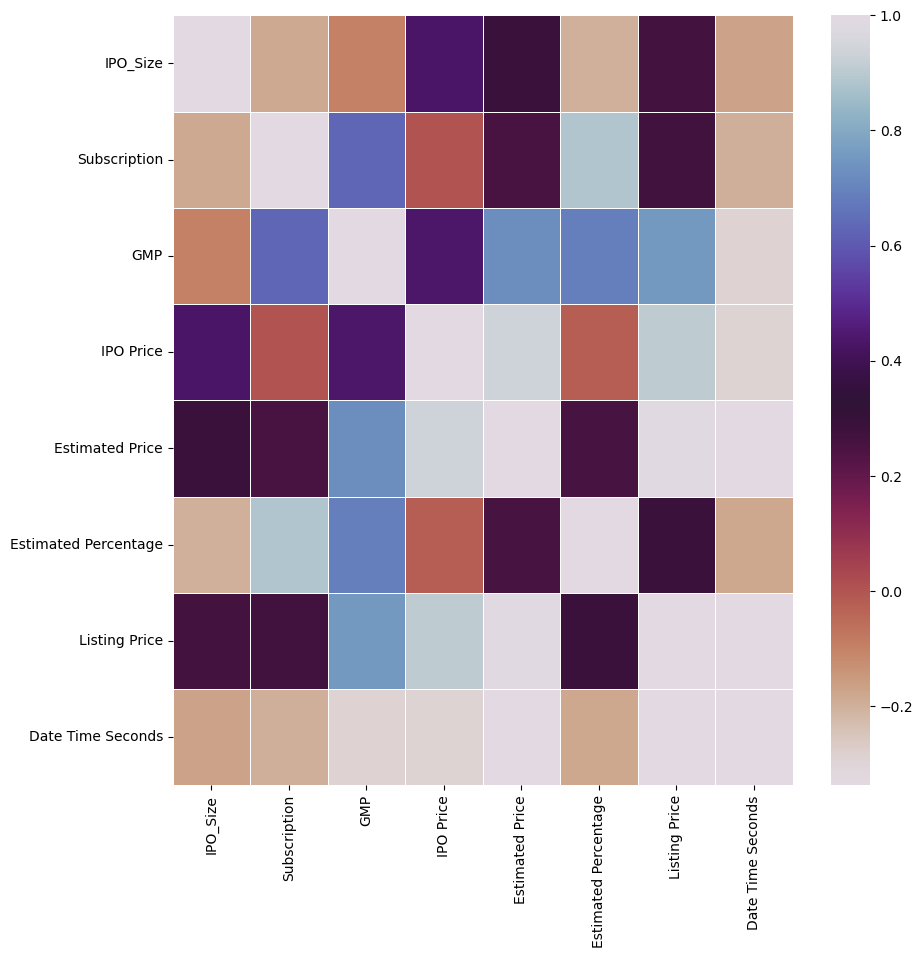

In [15]:
# We can create a heat map associated with the data to confirm our conclusions from the pair plot (note date time seconds 
# actually has a low inverse correlation).

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(data.corr(), linewidth=.5,cmap="twilight_r")
plt.show()

In [16]:
# Let's normalize the columns about their means in order to help our predictive models.

listingPriceScaleFactor = 0

for column in data:
    if column == 'Listing Price':
        listingPriceScaleFactor = data[column].mean()
    data[column] = data[column]/data[column].mean()

data.head()

,IPO_Size,Subscription,GMP,IPO Price,Estimated Price,Estimated Percentage,Listing Price,Date Time Seconds
0,0.558011,1.127804,0.260694,0.615439,0.548076,0.413719,0.532834,1.815783
1,0.328069,0.526191,0.446904,1.728466,1.485108,0.252481,1.392754,1.812625
2,0.309783,1.698102,0.148968,0.130944,0.134367,1.111166,0.124856,1.807888
3,1.138397,0.167825,0.223452,0.707100,0.615259,0.308727,0.580314,1.803151
4,1.271249,0.919401,1.489680,1.414199,1.428533,1.028672,1.457820,1.801572


In [17]:
# Note that we record the scale factor between our output listing price and actual listing prices for post processing.

print(listingPriceScaleFactor)

568.6573426573426


In [18]:
# We can see that our normalization routine greatly improved the differences between the column means and standard deviations.
# This will aid our predictive models in making more generalizable predictions.

data.describe(include='all')

,IPO_Size,Subscription,GMP,IPO Price,Estimated Price,Estimated Percentage,Listing Price,Date Time Seconds
count,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000
mean,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
std,1.762918,1.305223,1.744769,0.790599,0.839584,1.270229,0.859854,0.541146
min,0.040145,0.002646,-0.744840,0.054560,0.045968,-0.458299,0.043963,0.000000
25%,0.324613,0.079061,0.041897,0.405928,0.392493,0.075619,0.386876,0.548682
50%,0.495118,0.447461,0.325868,0.770389,0.783218,0.474547,0.780787,0.958418
75%,0.936188,1.575265,1.163813,1.309444,1.358697,1.535509,1.327689,1.545784
max,13.754247,7.200171,10.334657,4.692174,3.960288,5.751231,4.584483,1.815783


In [19]:
# Now some of the columns have names that do not cater to the predictive models we will be training.
# As a result lets rename them without spaces.

data['IPOPrice'] = data['IPO Price']
data['EstimatedPrice'] = data['Estimated Price']
data['EstimatedPercentage'] = data['Estimated Percentage']
data['ListingPrice'] = data['Listing Price']
data['DateTimeSeconds'] = data['Date Time Seconds']

data = data.drop(['IPO Price','Estimated Price','Estimated Percentage','Listing Price','Date Time Seconds'], axis=1)

# Now we have a data frame with acceptable names.
data.head()


,IPO_Size,Subscription,GMP,IPOPrice,EstimatedPrice,EstimatedPercentage,ListingPrice,DateTimeSeconds
0,0.558011,1.127804,0.260694,0.615439,0.548076,0.413719,0.532834,1.815783
1,0.328069,0.526191,0.446904,1.728466,1.485108,0.252481,1.392754,1.812625
2,0.309783,1.698102,0.148968,0.130944,0.134367,1.111166,0.124856,1.807888
3,1.138397,0.167825,0.223452,0.707100,0.615259,0.308727,0.580314,1.803151
4,1.271249,0.919401,1.489680,1.414199,1.428533,1.028672,1.457820,1.801572


In [20]:
# ***Analysis (model building and training)***

# Lets split the data into test train splits so that we can determine later on how generalizable our predictive models are
# post-training.

X_train, X_test = train_test_split(data, test_size=0.2, random_state= 5)


In [21]:
# We will also build a helper function to determine the R-Squared values associated with test data and predictions.

def test_rsquared(xtest,regModel):
    
    yPred = regModel.predict(xtest)
    yAverage = sum(xtest['ListingPrice'])/len(xtest['ListingPrice'])
    
    error = yPred - xtest['ListingPrice']
    
    ssResiduals = sum(error**2)
    ssTotal = sum((yPred - yAverage)**2)
    
    return 1-ssResiduals/ssTotal

In [22]:
# We will first build a simple linear regression model using our EDA conclusions from the pair plot.  We will use IPO Price,
# GMP and Estimated Price from other analysts to estimate the listing price.

modelPairPlotVars = smf.ols(formula='ListingPrice ~ IPOPrice + GMP + EstimatedPrice', data=X_train).fit()
modelPairPlotVars.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           ListingPrice   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     2740.
Date:                Sun, 10 Dec 2023   Prob (F-statistic):           3.39e-95
Time:                        15:23:43   Log-Likelihood:                 76.856
No. Observations:                 114   AIC:                            -147.7
Df Residuals:                     111   BIC:                            -139.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.0067      0.019      0.351      0.727      -0.031       0.045
IPOPrice           0.4588      0.010     44.081      0.000       0.438       0.479
GMP                0.1392      0.008     17.579      0.000       0.124       0.155
EstimatedPrice     0.3982      0.008     52.662      0.000       0.383       0.413
==============================================================================
Omnibus:                       25.570   Durbin-Watson:                   1.688
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              113.037
Skew:                           0.567   Prob(JB):                     2.85e-25
Kurtosis:                       7.745   Cond. No.                     1.12e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.5e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [23]:
# We will make an additional linear regression model that simply tosses all of the available features into the model
# and attempts to compute the listing price.

# Ironically, both the all variables model and the pair plot derived model end up with the same adjusted R squared value.
# Furthermore, we can see below that the additional variables didn't really have any effect on the predictive model as the P>|t|
# values in the model summary are all above 0.05 aside from those we identified in the pair plot (GMP, IPO price, and
# analyst estimated price).

modelAllVars = smf.ols(formula='ListingPrice ~ IPOPrice + GMP + EstimatedPrice + DateTimeSeconds + Subscription + IPO_Size + EstimatedPercentage', data=X_train).fit()
modelAllVars.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           ListingPrice   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     906.8
Date:                Sun, 10 Dec 2023   Prob (F-statistic):           2.66e-89
Time:                        15:23:43   Log-Likelihood:                 78.509
No. Observations:                 114   AIC:                            -143.0
Df Residuals:                     107   BIC:                            -123.9
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0042      0.036      0.117      0.907      -0.067       0.076
IPOPrice                0.4648      0.015     31.188      0.000       0.435       0.494
GMP                     0.1336      0.014      9.542      0.000       0.106       0.161
EstimatedPrice          0.4019      0.010     39.589      0.000       0.382       0.422
DateTimeSeconds         0.0003      0.023      0.012      0.990      -0.045       0.045
Subscription           -0.0316      0.019     -1.665      0.099      -0.069       0.006
IPO_Size               -0.0040      0.010     -0.411      0.682      -0.024       0.015
EstimatedPercentage     0.0333      0.022      1.546      0.125      -0.009       0.076
==============================================================================
Omnibus:                       29.166   Durbin-Watson:                   1.788
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              129.947
Skew:                           0.696   Prob(JB):                     6.06e-29
Kurtosis:                       8.042   Cond. No.                     1.16e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 9.85e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [24]:
# Now we will build a more complicated regression model with a polynomial fit.  We include many combinations of variables, run the training
# routine, and output its summary.  Let's examine the P>|t| values to see which variables and compound variables we can drop.

polyFull = smf.ols(formula='ListingPrice ~ IPO_Size*EstimatedPrice*IPOPrice + EstimatedPercentage*EstimatedPrice*IPOPrice + Subscription*IPOPrice + IPO_Size*IPOPrice + DateTimeSeconds*EstimatedPrice + IPOPrice*DateTimeSeconds + IPOPrice*EstimatedPrice + IPOPrice*GMP + IPOPrice + GMP + EstimatedPrice + DateTimeSeconds + Subscription + IPO_Size + EstimatedPercentage', data=X_train).fit()
polyFull.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           ListingPrice   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     459.0
Date:                Sun, 10 Dec 2023   Prob (F-statistic):           5.76e-84
Time:                        15:23:43   Log-Likelihood:                 104.84
No. Observations:                 114   AIC:                            -173.7
Df Residuals:                      96   BIC:                            -124.4
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
===============================================================================================================
                                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
Intercept                                       0.0046      0.059      0.079      0.937      -0.112       0.121
IPO_Size                                       -0.0036      0.019     -0.189      0.850      -0.041       0.034
EstimatedPrice                                  0.4115      0.055      7.465      0.000       0.302       0.521
IPO_Size:EstimatedPrice                        -0.1270      0.039     -3.256      0.002      -0.204      -0.050
IPOPrice                                        0.4971      0.063      7.935      0.000       0.373       0.621
IPO_Size:IPOPrice                               0.1272      0.038      3.323      0.001       0.051       0.203
EstimatedPrice:IPOPrice                        -0.1018      0.032     -3.147      0.002      -0.166      -0.038
IPO_Size:EstimatedPrice:IPOPrice               -0.0002      0.006     -0.032      0.975      -0.012       0.011
EstimatedPercentage                            -0.0150      0.034     -0.443      0.659      -0.082       0.052
EstimatedPercentage:EstimatedPrice              0.2008      0.079      2.531      0.013       0.043       0.358
EstimatedPercentage:IPOPrice                   -0.1613      0.337     -0.478      0.633      -0.831       0.508
EstimatedPercentage:EstimatedPrice:IPOPrice    -0.1881      0.041     -4.608      0.000      -0.269      -0.107
Subscription                                    0.0640      0.030      2.155      0.034       0.005       0.123
Subscription:IPOPrice                          -0.1424      0.037     -3.885      0.000      -0.215      -0.070
DateTimeSeconds                                -0.0430      0.036     -1.182      0.240      -0.115       0.029
DateTimeSeconds:EstimatedPrice                 -0.1037      0.095     -1.093      0.277      -0.292       0.085
IPOPrice:DateTimeSeconds                        0.1683      0.098      1.721      0.089      -0.026       0.362
GMP                                             0.0460      0.344      0.134      0.894      -0.637       0.729
IPOPrice:GMP                                    0.3424      0.062      5.495      0.000       0.219       0.466
==============================================================================
Omnibus:                       22.110   Durbin-Watson:                   1.749
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               51.039
Skew:                           0.720   Prob(JB):                     8.26e-12
Kurtosis:                       5.944   Cond. No.                     1.55e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.34e-30. This

In [25]:
# Using the P>|t| column, we can reduce the polynomial model from one that contains 15 variables and 
# compound variables to one that contains 8. This is good because a smaller model will likely be more generalizable and
# computationally efficient.  Some variables and compound variables still exist in the rows of the summary
# for this model, despite not actually being listed in the formula and having been removed.

polyReduced = smf.ols(formula='ListingPrice ~ EstimatedPercentage*EstimatedPrice*IPOPrice + Subscription*IPOPrice + IPO_Size*IPOPrice + IPOPrice*DateTimeSeconds + IPOPrice*EstimatedPrice + IPOPrice*GMP + IPOPrice + EstimatedPrice', data=X_train).fit()
polyReduced.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           ListingPrice   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                     512.0
Date:                Sun, 10 Dec 2023   Prob (F-statistic):           1.26e-85
Time:                        15:23:43   Log-Likelihood:                 98.321
No. Observations:                 114   AIC:                            -166.6
Df Residuals:                      99   BIC:                            -125.6
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
===============================================================================================================
                                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
Intercept                                       0.0151      0.053      0.284      0.777      -0.090       0.121
EstimatedPercentage                             0.0190      0.034      0.562      0.575      -0.048       0.086
EstimatedPrice                                  0.3979      0.051      7.877      0.000       0.298       0.498
EstimatedPercentage:EstimatedPrice              0.1995      0.079      2.527      0.013       0.043       0.356
IPOPrice                                        0.5091      0.052      9.856      0.000       0.407       0.612
EstimatedPercentage:IPOPrice                   -0.1066      0.350     -0.304      0.761      -0.801       0.588
EstimatedPrice:IPOPrice                        -0.0762      0.027     -2.848      0.005      -0.129      -0.023
EstimatedPercentage:EstimatedPrice:IPOPrice    -0.1527      0.040     -3.852      0.000      -0.231      -0.074
Subscription                                    0.0216      0.028      0.781      0.436      -0.033       0.077
Subscription:IPOPrice                          -0.0663      0.030     -2.229      0.028      -0.125      -0.007
IPO_Size                                       -0.0088      0.014     -0.613      0.542      -0.037       0.020
IPO_Size:IPOPrice                               0.0177      0.008      2.310      0.023       0.002       0.033
DateTimeSeconds                                -0.0387      0.037     -1.048      0.297      -0.112       0.035
IPOPrice:DateTimeSeconds                        0.0559      0.034      1.657      0.101      -0.011       0.123
GMP                                            -0.0768      0.355     -0.216      0.829      -0.782       0.628
IPOPrice:GMP                                    0.2712      0.056      4.825      0.000       0.160       0.383
==============================================================================
Omnibus:                       27.125   Durbin-Watson:                   1.834
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               85.442
Skew:                           0.771   Prob(JB):                     2.80e-19
Kurtosis:                       6.951   Cond. No.                     9.41e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.12e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [26]:
# Now lets look at our test performance.  We can see some interesting trends.  Firstly, our simple pair plot derived model
# performs the best.  It performed better during testing than just including a model with all available variables.
# Additionally, although the reduced polynomial regression model performed worse than our simple pair plot derived model,
# it did perform substantially better than the full polynomial regression model, as expected.  This is likely because
# the full polynomial model is too highly variant and not generalizable.

# In conclusion we can see our pair plot derived linear model performed the best.

print("Full linear model test data R2 performance: ",test_rsquared(X_test,modelAllVars))
print("Pair plot derived test data R2 performance: ",test_rsquared(X_test,modelPairPlotVars))
print("Full poly model test data R2 performance: ",test_rsquared(X_test,polyFull))
print("Reduced poly model test data R2 performance: ",test_rsquared(X_test,polyReduced))

Full linear model test data R2 performance:  0.9821902270488412
Pair plot derived test data R2 performance:  0.9833951959137944
Full poly model test data R2 performance:  0.9542959774966852
Reduced poly model test data R2 performance:  0.9731802181265312


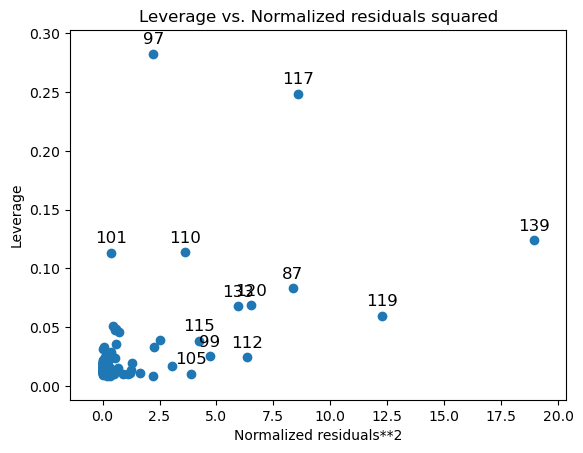

In [27]:
# Let's take our candidate pair plot derived regression model and evaluate if we can improve it by removing any outliers
# in the original data set.

# We can see that there are a number of points we should consider removing from the data set in order to attempt to improve
# its testing accuracy.  Points 97, 117, and 139 should be considered for removal because of their high leverage and 
# normalized residuals.

sm.graphics.plot_leverage_resid2(modelPairPlotVars)
plt.show()

In [28]:
# Let's remove the outliers and store the new data set in a new data frame.

outliers = [97,117,139]
X_train_no_outliers = X_train.drop(outliers)

# Let's retrain the pair plot derived model.
modelPairPlotVarsNoOutliers = smf.ols(formula='ListingPrice ~ IPOPrice + GMP + EstimatedPrice', data=X_train_no_outliers).fit()
modelPairPlotVarsNoOutliers.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           ListingPrice   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                     2518.
Date:                Sun, 10 Dec 2023   Prob (F-statistic):           2.48e-91
Time:                        15:23:43   Log-Likelihood:                 90.151
No. Observations:                 111   AIC:                            -174.3
Df Residuals:                     108   BIC:                            -166.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.0074      0.018      0.416      0.679      -0.028       0.043
IPOPrice           0.4585      0.011     42.331      0.000       0.437       0.480
GMP                0.1391      0.009     16.307      0.000       0.122       0.156
EstimatedPrice     0.3979      0.008     50.810      0.000       0.382       0.413
==============================================================================
Omnibus:                       17.113   Durbin-Watson:                   1.823
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               73.214
Skew:                           0.165   Prob(JB):                     1.26e-16
Kurtosis:                       6.965   Cond. No.                     2.15e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.34e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [29]:
# Let's retrain the reduced polynomial regression model.

polyReducedNoOutliers = smf.ols(formula='ListingPrice ~ EstimatedPercentage*EstimatedPrice*IPOPrice + Subscription*IPOPrice + IPO_Size*IPOPrice + IPOPrice*DateTimeSeconds + IPOPrice*EstimatedPrice + IPOPrice*GMP + IPOPrice + EstimatedPrice', data=X_train_no_outliers).fit()
polyReducedNoOutliers.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           ListingPrice   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                     433.6
Date:                Sun, 10 Dec 2023   Prob (F-statistic):           3.96e-80
Time:                        15:23:43   Log-Likelihood:                 106.76
No. Observations:                 111   AIC:                            -183.5
Df Residuals:                      96   BIC:                            -142.9
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
===============================================================================================================
                                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
Intercept                                      -0.0147      0.053     -0.281      0.780      -0.119       0.089
EstimatedPercentage                            -0.0216      0.034     -0.640      0.524      -0.089       0.045
EstimatedPrice                                  0.4413      0.049      9.024      0.000       0.344       0.538
EstimatedPercentage:EstimatedPrice              0.0861      0.087      0.991      0.324      -0.086       0.258
IPOPrice                                        0.4817      0.053      9.109      0.000       0.377       0.587
EstimatedPercentage:IPOPrice                   -0.1933      0.318     -0.607      0.545      -0.825       0.439
EstimatedPrice:IPOPrice                        -0.0496      0.028     -1.748      0.084      -0.106       0.007
EstimatedPercentage:EstimatedPrice:IPOPrice    -0.0521      0.062     -0.837      0.405      -0.176       0.071
Subscription                                    0.0473      0.027      1.779      0.078      -0.005       0.100
Subscription:IPOPrice                          -0.1099      0.030     -3.648      0.000      -0.170      -0.050
IPO_Size                                        0.0002      0.016      0.015      0.988      -0.031       0.032
IPO_Size:IPOPrice                               0.0097      0.013      0.726      0.470      -0.017       0.036
DateTimeSeconds                                -0.0268      0.034     -0.788      0.432      -0.094       0.041
IPOPrice:DateTimeSeconds                        0.0437      0.031      1.409      0.162      -0.018       0.105
GMP                                             0.2689      0.332      0.810      0.420      -0.390       0.927
IPOPrice:GMP                                    0.0886      0.087      1.022      0.309      -0.083       0.261
==============================================================================
Omnibus:                       39.106   Durbin-Watson:                   1.939
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              131.383
Skew:                           1.183   Prob(JB):                     2.96e-29
Kurtosis:                       7.776   Cond. No.                     1.01e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.37e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [30]:
# Unfortunately, our outlier removal made final testing R2 performance worse.  

print("Pair plot derived test data R2 performance: ",test_rsquared(X_test,modelPairPlotVarsNoOutliers))
print("Reduced Poly derived test data R2 performance: ",test_rsquared(X_test,polyReducedNoOutliers))

Pair plot derived test data R2 performance:  0.9833572412131172
Reduced Poly derived test data R2 performance:  0.9642263814168424


In [31]:
# What happens if we re evaluate our outlier chart above and only remove points with high leverage? Maybe this will do a better
# job of producing a model that is more generalizable?  Let's only remove points 97 and 117.

# Recreate the dataset with no outliers.

outliers = [97,117]
X_train_no_outliers = X_train.drop(outliers)

In [32]:
# Let's retrain the pair plot derived model.
modelPairPlotVarsNoOutliers = smf.ols(formula='ListingPrice ~ IPOPrice + GMP + EstimatedPrice', data=X_train_no_outliers).fit()
modelPairPlotVarsNoOutliers.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           ListingPrice   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                     2593.
Date:                Sun, 10 Dec 2023   Prob (F-statistic):           1.24e-92
Time:                        15:23:44   Log-Likelihood:                 81.671
No. Observations:                 112   AIC:                            -157.3
Df Residuals:                     109   BIC:                            -149.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.0074      0.019     -0.389      0.698      -0.045       0.030
IPOPrice           0.4647      0.012     39.793      0.000       0.442       0.488
GMP                0.1469      0.009     16.173      0.000       0.129       0.165
EstimatedPrice     0.4043      0.008     48.320      0.000       0.388       0.421
==============================================================================
Omnibus:                       18.537   Durbin-Watson:                   1.823
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               94.085
Skew:                          -0.065   Prob(JB):                     3.71e-21
Kurtosis:                       7.488   Cond. No.                     8.58e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 9.33e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [33]:
# Let's retrain the reduced polynomial regression model.
polyReducedNoOutliers = smf.ols(formula='ListingPrice ~ EstimatedPercentage*EstimatedPrice*IPOPrice + Subscription*IPOPrice + IPO_Size*IPOPrice + IPOPrice*DateTimeSeconds + IPOPrice*EstimatedPrice + IPOPrice*GMP + IPOPrice + EstimatedPrice', data=X_train_no_outliers).fit()
polyReducedNoOutliers.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           ListingPrice   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                     433.9
Date:                Sun, 10 Dec 2023   Prob (F-statistic):           8.33e-81
Time:                        15:23:44   Log-Likelihood:                 96.790
No. Observations:                 112   AIC:                            -163.6
Df Residuals:                      97   BIC:                            -122.8
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
===============================================================================================================
                                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
Intercept                                      -0.0099      0.058     -0.171      0.864      -0.125       0.105
EstimatedPercentage                             0.0244      0.036      0.686      0.494      -0.046       0.095
EstimatedPrice                                  0.4207      0.054      7.841      0.000       0.314       0.527
EstimatedPercentage:EstimatedPrice              0.1781      0.093      1.912      0.059      -0.007       0.363
IPOPrice                                        0.5303      0.057      9.283      0.000       0.417       0.644
EstimatedPercentage:IPOPrice                   -0.1311      0.351     -0.374      0.709      -0.827       0.565
EstimatedPrice:IPOPrice                        -0.0750      0.031     -2.444      0.016      -0.136      -0.014
EstimatedPercentage:EstimatedPrice:IPOPrice    -0.1164      0.067     -1.740      0.085      -0.249       0.016
Subscription                                    0.0279      0.029      0.964      0.337      -0.030       0.085
Subscription:IPOPrice                          -0.0768      0.032     -2.381      0.019      -0.141      -0.013
IPO_Size                                        0.0031      0.018      0.174      0.863      -0.032       0.038
IPO_Size:IPOPrice                               0.0010      0.015      0.069      0.945      -0.028       0.030
DateTimeSeconds                                -0.0354      0.037     -0.946      0.347      -0.110       0.039
IPOPrice:DateTimeSeconds                        0.0504      0.034      1.477      0.143      -0.017       0.118
GMP                                            -0.0464      0.358     -0.130      0.897      -0.757       0.664
IPOPrice:GMP                                    0.2327      0.089      2.609      0.011       0.056       0.410
==============================================================================
Omnibus:                       21.043   Durbin-Watson:                   1.748
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               59.983
Skew:                           0.598   Prob(JB):                     9.44e-14
Kurtosis:                       6.380   Cond. No.                     2.10e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.59e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [34]:
# What we've found is that although removing the two outliers with high leverage actually made our training R2 performance
# slightly worse in both models' cases, they are not more generalizable and their testing R2 performance has improved.

print("Pair plot derived test data R2 performance: ",test_rsquared(X_test,modelPairPlotVarsNoOutliers))
print("Reduced Poly derived test data R2 performance: ",test_rsquared(X_test,polyReducedNoOutliers))

Pair plot derived test data R2 performance:  0.9842363935467288
Reduced Poly derived test data R2 performance:  0.9818166105015405


In [35]:
# As our final inquiry, let's try to train a support vector regressor to perform the prediction task.

# First we will need some slightly new data sets for training.  Sklearn's SVR class works with numpy arrays and not pandas dataframes.
# We will also drop the outliers with high leverage found previously.

# Since grid search performs cross-validation, we do not need to further split X_train into X_train and X_val.

# The logic below just converts the original no outliers X_train and X_test dfs to SVR x_train, y_train, x_test, 
# and y_test sets.  (I also had to unpack y_test and y_train into 1d arrays from 2d arrays with single elements).

svr_x_train = (X_train_no_outliers.drop('ListingPrice',axis = 1)).to_numpy()
svr_x_test = (X_test.drop('ListingPrice',axis = 1)).to_numpy()
svr_y_train1 = (X_train_no_outliers.drop(['IPO_Size','Subscription','GMP','IPOPrice','EstimatedPrice','EstimatedPercentage','DateTimeSeconds'],axis = 1)).to_numpy()
svr_y_test1 = (X_test.drop(['IPO_Size','Subscription','GMP','IPOPrice','EstimatedPrice','EstimatedPercentage','DateTimeSeconds'],axis = 1)).to_numpy()

# Unpack y_test and y_train.
svr_y_train = []
for element in svr_y_train1:
    svr_y_train.append(element[0])
    
svr_y_test = []
for element in svr_y_test1:
    svr_y_test.append(element[0])

In [36]:
# Let's set up a grid search hyperparameter sweep and train the SVR.

# We will look at both linear and rbf kernels with a large sweep through gamma and C hyperparamters.
parameters = {'gamma':[0.00001,0.005,0.001,0.0032,0.016,0.04,.2,1,2,4,8,16,32],'C':[0.0005,0.001,0.0032,0.016,0.04,0.05,0.08,0.1,0.12,0.125,0.13,0.15,0.175,0.2,0.5,1,2,4,8,16,32,50],'kernel':['rbf','linear']}
grid = GridSearchCV(SVR(), parameters,cv=3)
grid.fit(svr_x_train,svr_y_train)


GridSearchCV(cv=3, estimator=SVR(),
             param_grid={'C': [0.0005, 0.001, 0.0032, 0.016, 0.04, 0.05, 0.08,
                               0.1, 0.12, 0.125, 0.13, 0.15, 0.175, 0.2, 0.5, 1,
                               2, 4, 8, 16, 32, 50],
                         'gamma': [1e-05, 0.005, 0.001, 0.0032, 0.016, 0.04,
                                   0.2, 1, 2, 4, 8, 16, 32],
                         'kernel': ['rbf', 'linear']})

In [37]:
# We will identify and store the final SVR model.

print(grid.best_estimator_)
print("Best score: " , grid.best_score_)
print("Best params: " , grid.best_params_)
finalSVR = grid.best_estimator_

SVR(C=0.13, gamma=1e-05, kernel='linear')
Best score:  0.9656095875309191
Best params:  {'C': 0.13, 'gamma': 1e-05, 'kernel': 'linear'}


In [38]:
# The SVR needs a new R2 test performance helper function that consumes numpy arrays.

def test_rsquared_svr(xtest,ytest,regModel):
    
    yPred = regModel.predict(xtest)
    yAverage = sum(ytest)/len(ytest)
    
    error = yPred - ytest
    
    ssResiduals = sum(error**2)
    ssTotal = sum((yPred - yAverage)**2)
    
    return 1-ssResiduals/ssTotal

In [39]:
# We can obtain our best SVR's R2 test performance with this helper function.

print(test_rsquared_svr(svr_x_test,svr_y_test,finalSVR))

0.9798836042211476


In [40]:
# ***Results***

# The most simple way we can view our results is to evaluate the normalized residual squared performance for each of our three
# models.

# We can see that although the polynomial regression and SVR performance is good, it is not better than our simple
# pair plot derived linear regression model.  Unfortunately, sometimes greater complexity leads to less generalizability
# and the less variant simple linear model appears to perform quite a bit better than the other two.

print("Pair plot derived test data R2 performance: ",test_rsquared(X_test,modelPairPlotVarsNoOutliers))
print("Reduced Poly derived test data R2 performance: ",test_rsquared(X_test,polyReducedNoOutliers))
print("Best SVR R2 performance: ",test_rsquared_svr(svr_x_test,svr_y_test,finalSVR))

Pair plot derived test data R2 performance:  0.9842363935467288
Reduced Poly derived test data R2 performance:  0.9818166105015405
Best SVR R2 performance:  0.9798836042211476


In [41]:
# We will now build two helper functions to evaluate the standard deviations in dollar terms of our predictive computational
# models.

def standard_dev(xtest,regModel):
    
    yPred = regModel.predict(xtest)*listingPriceScaleFactor
    error = yPred - xtest['ListingPrice']*listingPriceScaleFactor
    
    errAv = sum(error)/len(error)
    
    stdev = (sum((error - errAv)**2)/len(error))**0.5
    
    return stdev

def standard_dev_svr(xtest,ytest,regModel):
    
    ytestScale = []
    
    for k in ytest:
        ytestScale.append(k*listingPriceScaleFactor)
    
    yPred = regModel.predict(xtest)*listingPriceScaleFactor
    error = yPred - ytestScale
    errAv = sum(error)/len(error)
    
    stdev = (sum((error - errAv)**2)/len(error))**0.5
    
    return stdev

In [42]:
# Let's take a look at how wrong we can expect our models to be given any particular IPO situation. We will a 2-sigma
# or 95% confidence interval for our analysis.  These are our models' final actionable results.  With these estimates
# of probabilistic accuracy, if we had a financial company, we could use them and hedge bets against the IPOs of a given
# company using our listing price estimate.

print("Pair plot 95% confidence interval in dollars: ",2*standard_dev(X_test,modelPairPlotVarsNoOutliers))
print("Reduced poly 95% confidence interval in dollars: ",2*standard_dev(X_test,polyReducedNoOutliers))
print("SVR 95% confidence interval in dollars: ",2*standard_dev_svr(svr_x_test,svr_y_test,finalSVR))

Pair plot 95% confidence interval in dollars:  109.53579746994036
Reduced poly 95% confidence interval in dollars:  111.70319959174915
SVR 95% confidence interval in dollars:  119.84394482797165


In [43]:
# As a sanity check, how well does the pure 'analyst estimated price' model with no EDA perform?

# Build the model.
analysts = smf.ols(formula='ListingPrice ~ EstimatedPrice', data=X_train).fit()

# Evaluate its 95% confidence interval.
print("Analyst 95% confidence interval in dollars: ",2*standard_dev(X_test,analysts))

Analyst 95% confidence interval in dollars:  130.95015785736393


In [44]:
# ***Conclusions***

# We have developed three predictive computational models for evaluating the listing price of any given company's IPO
# using features presented within the given data set. After evaluating which features are highly correlated with the listing
# prices within the given data set, we derived a simple linear regression model.  Then using a wide variety of different
# features and compound features, we derived a much more complicated polynomial regression model. Finally, with a very wide
# hyperparameter grid seach, we created a suppor vector regressor to also predict the listing price of a given IPO.

# Using the normalized residuals squared performance metric, we quickly found that the simple linear regression model based
# on features that have a high correlation to the dependent variable (listing price) performed the best. Upon capturing
# its inaccuracy in the form of a 95% confidence interval with units in dollars, we found it was capable of determining
# the listing price of a given IPO to within 110$.  This is a 15% improvement over the analyst estimate of 130$.  Considering
# that the individual contributor on Kaggle obtained this data from actual sources and the analyst estimates are from actual
# financial companies, the results were very promising and this 15% improvement is actually quite impressive.

# Cross-verification of estimates and analysis is quite common in the financial industry.  A quick yahoo search on yahoo finance
# of company information reveals 'analyst trend' information that provides compounded information across a diverse set of 
# analyst data, typically with average estimates reported.  I found it interesting that combining additional information could
# improve the accuracy of analyst estimates.



In [45]:
# Let's look at the implications below.

# Referring back to our original set of data, we can predict the listing price of Cello World Limited.  We can then find our
# minimum 95% confidence interval and compare it to the IPO price of Cello Limited.

# We can conclude that there is far more than a 95% chance that the IPO price is undervalued based on our prediction of 822.3$.

# Make prediction.
out = modelPairPlotVarsNoOutliers.predict(X_train)*listingPriceScaleFactor

# Prediction
print("Cello Predicted Listing Price: ",out[4])

# Subtract confidence interval from prediction.
print("Minimum 95% confidence interval for Cello: ", (out[4] - 2*standard_dev(X_test,modelPairPlotVarsNoOutliers)))

# IPO Price
print("Cello IPO Price: 648")

Cello Predicted Listing Price:  822.3057984624305
Minimum 95% confidence interval for Cello:  712.7700009924902
Cello IPO Price: 648


In [46]:
# Now we can look at what other people on the grey market will be observing based on analyst estimates.

# We can see that their lower confidence interval is substantially closer to the IPO price and the estimate would also be lower.
# As a result, in theory, we could actually likely take advantage of this situation and offer higher prices knowing that
# the true listing price upon the company actually being listed will likely be higher than what others are anticipating.

# The idea is that taking such conclusions and force-multiplying with large amounts of money could turn large profits
# in very short amounts of time!

# Make prediction.
out = analysts.predict(X_train)*listingPriceScaleFactor

# Prediction
print("Cello Predicted Listing Price: ",out[4])

# Subtract confidence interval from prediction.
print("Minimum 95% confidence interval for Cello: ", (out[4] - 2*standard_dev(X_test,analysts)))

# IPO Price
print("Cello IPO Price: 648")

Cello Predicted Listing Price:  817.2173194827301
Minimum 95% confidence interval for Cello:  686.2671616253662
Cello IPO Price: 648
